In [1]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
# Import data using Polars
train_df = pl.read_csv(
    source = "data/training_set_VU_DM.csv",
    null_values=["null", "NaN", "NULL"]
    )

In [52]:
# Print basic information about the data
print(train_df.head())
print(train_df.shape)

shape: (5, 54)
┌─────────┬────────────┬─────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ srch_id ┆ date_time  ┆ site_id ┆ visitor_lo ┆ … ┆ comp8_rate ┆ click_boo ┆ gross_boo ┆ booking_b │
│ ---     ┆ ---        ┆ ---     ┆ cation_cou ┆   ┆ _percent_d ┆ l         ┆ kings_usd ┆ ool       │
│ i64     ┆ str        ┆ i64     ┆ ntry_id    ┆   ┆ iff        ┆ ---       ┆ ---       ┆ ---       │
│         ┆            ┆         ┆ ---        ┆   ┆ ---        ┆ i64       ┆ f64       ┆ i64       │
│         ┆            ┆         ┆ i64        ┆   ┆ i64        ┆           ┆           ┆           │
╞═════════╪════════════╪═════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 1       ┆ 2013-04-04 ┆ 12      ┆ 187        ┆ … ┆ null       ┆ 0         ┆ null      ┆ 0         │
│         ┆ 08:32:15   ┆         ┆            ┆   ┆            ┆           ┆           ┆           │
│ 1       ┆ 2013-04-04 ┆ 12      ┆ 187        ┆ … ┆ null       ┆ 0         ┆

In [ ]:
# We note that the data contains 3 buckets of information:
# 1) Customer information 
# 2) Property information 
# 3) Search information
# X) Competitor information

def get_columns(df: pl.DataFrame) -> dict:
    visitor_cols = [col for col in df.columns if "visitor_" in col]
    
    search_cols = [col for col in df.columns if any(substr in col for substr in [
        "srch_", "search_", "day_of_week", "month", "date_time", "weekend", "holiday"
    ])]
    
    booking_cols = [col for col in df.columns if any(substr in col for substr in [
        "prop_", "price", "promotion", "position", "click_bool", "booking_bool"
    ]) and col not in search_cols]

    return {
        "visitor": visitor_cols,
        "search": search_cols,
        "booking": booking_cols
    }

# Get the columns for each category
columns = get_columns(train_df)
print("Visitor columns:", columns["visitor"])
print("Search columns:", columns["search"])
print("Booking columns:", columns["booking"])

Visitor columns: ['visitor_location_country_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd']
Search columns: ['srch_id', 'date_time', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'srch_query_affinity_score']
Booking columns: ['prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag', 'click_bool', 'booking_bool']


In [54]:
# We first clean the visitor columns
train_df.select(
    columns["visitor"]
).describe()

def process_visitor_history(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        # Ensure correct data type
        pl.col("visitor_hist_starrating").cast(pl.Float64),
        pl.col("visitor_hist_adr_usd").cast(pl.Float64),

        # Binary flags: is info present?
        pl.col("visitor_hist_starrating").is_not_null().cast(pl.Int8).alias("visitor_has_starrating_info"),
        pl.col("visitor_hist_adr_usd").is_not_null().cast(pl.Int8).alias("visitor_has_adr_info"),

        # Fill nulls with sentinel (-1) for dense model inputs
        pl.col("visitor_hist_starrating").fill_null(-1).alias("visitor_hist_starrating_dense").cast(pl.Float64),
        pl.col("visitor_hist_adr_usd").fill_null(-1).alias("visitor_hist_adr_usd_dense").cast(pl.Float64)
    ])

# Input visitor feature for the model 
process_visitor_history(train_df).select(
    [
        "visitor_has_starrating_info",
        "visitor_has_adr_info",
        "visitor_hist_starrating_dense",
        "visitor_hist_adr_usd_dense"
    ]
).describe()

statistic,visitor_has_starrating_info,visitor_has_adr_info,visitor_hist_starrating_dense,visitor_hist_adr_usd_dense
str,f64,f64,f64,f64
"""count""",4.958347e6,4.958347e6,4.958347e6,4.958347e6
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",0.050796,0.051023,-0.7778,8.032165
"""std""",0.219582,0.220044,0.973122,45.872174
"""min""",0.0,0.0,-1.0,-1.0
"""25%""",0.0,0.0,-1.0,-1.0
"""50%""",0.0,0.0,-1.0,-1.0
"""75%""",0.0,0.0,-1.0,-1.0
"""max""",1.0,1.0,5.0,1958.7


In [64]:
def process_date_time(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns([
        # Parse date_time string into datetime format
        pl.col("date_time").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S").alias("parsed_date")
    ])
    
    df = df.with_columns([
        pl.col("parsed_date").dt.year().alias("year"),
        pl.col("parsed_date").dt.month().alias("month"),
        pl.col("parsed_date").dt.day().alias("day"), 
        pl.col("parsed_date").dt.hour().alias("search_hour"),
        pl.col("parsed_date").dt.weekday().alias("day_of_week"),  
        pl.col("parsed_date").dt.weekday().is_in([6, 7]).cast(pl.Int8).alias("is_weekend_search"),
        (
            pl.col("parsed_date").dt.year().cast(pl.Utf8) + 
            pl.col("parsed_date").dt.month().cast(pl.Utf8).str.zfill(2)
        ).alias("year_month")
    ])
    
    return df


In [66]:
train_df = process_date_time(train_df)
train_df.select(["year", "month", "day_of_week", "is_weekend_search"]).describe()


statistic,year,month,day_of_week,is_weekend_search
str,f64,f64,f64,f64
"""count""",4.958347e6,4.958347e6,4.958347e6,4.958347e6
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",2012.803169,5.164621,3.824736,0.243891
"""std""",0.397603,3.492702,1.980819,0.429428
"""min""",2012.0,1.0,1.0,0.0
"""25%""",2013.0,3.0,2.0,0.0
"""50%""",2013.0,4.0,4.0,0.0
"""75%""",2013.0,6.0,5.0,0.0
"""max""",2013.0,12.0,7.0,1.0


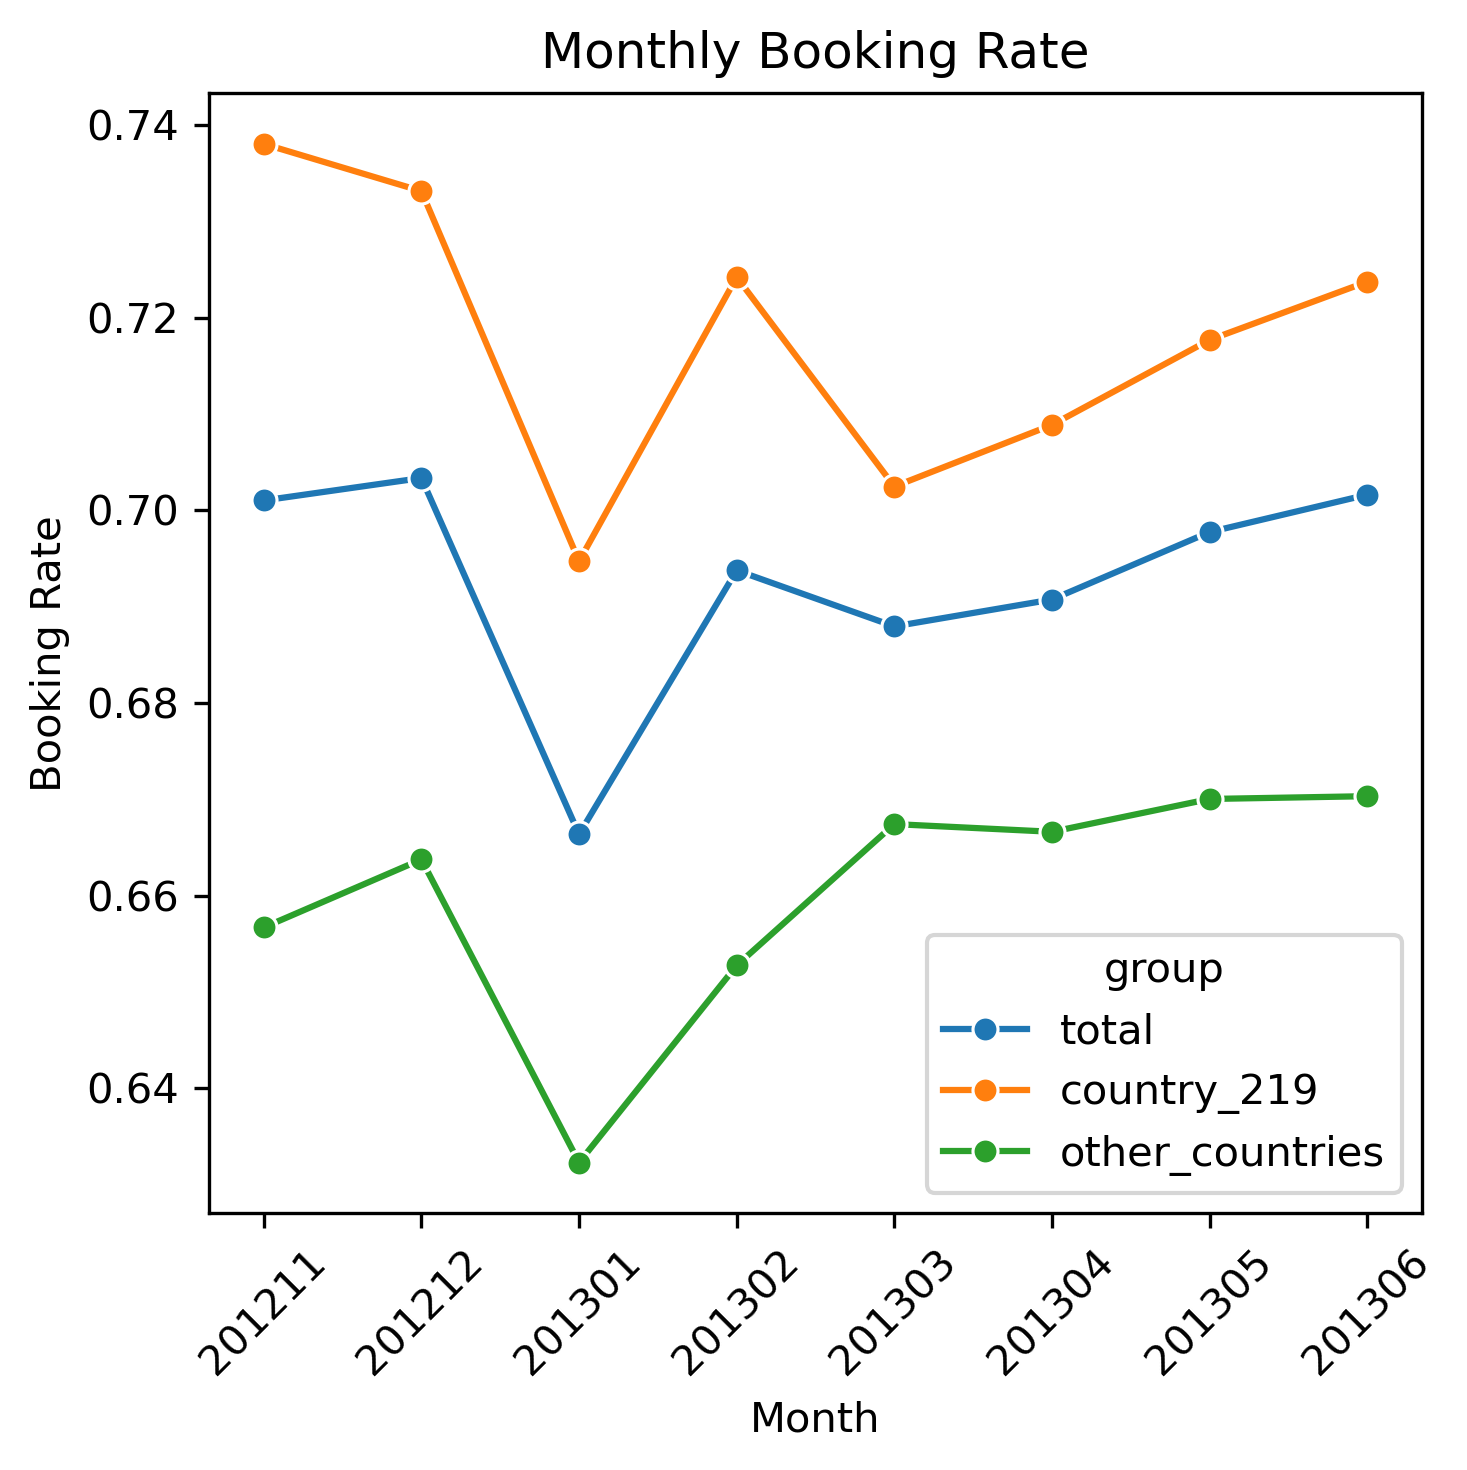

In [68]:
# The relationship between whether people will book a hotel depends on the month is affected by country_id=219
# https://ajourneyintodatascience.quora.com/Learning-to-Rank-Personalize-Expedia-Hotel-Searches-ICDM-2013-http-ajourneyintodatascience-ryin-main-quora-com-Le
# Let's verify this by plotting the booking rate over time and see if we can confirm this pattern

train_df = train_df.with_columns([
    # Let's see the overall pattern over linear time
    (pl.col("year").cast(pl.Utf8) + pl.col("month").cast(pl.Utf8).str.zfill(2)).alias("year_month"),
    pl.col("booking_bool").cast(pl.Int8)
])


def compute_booking_rate(df: pl.DataFrame, group_name: str) -> pl.DataFrame:
    return (
        df.group_by("year_month")
        .agg([
            pl.col("booking_bool").sum().alias("bookings"),
            pl.col("srch_id").n_unique().alias("searches")
        ])
        .with_columns([
            (pl.col("bookings") / pl.col("searches")).alias("booking_rate"),
            pl.lit(group_name).alias("group")
        ])
        .sort("year_month")
    )

# Compute booking rates and combine
total = compute_booking_rate(train_df, "total")
c219 = compute_booking_rate(train_df.filter(pl.col("visitor_location_country_id") == 219), "country_219")
others = compute_booking_rate(train_df.filter(pl.col("visitor_location_country_id") != 219), "other_countries")

df_plot = pl.concat([total, c219, others]).to_pandas()

# Plot
plt.figure(figsize=(5, 5), dpi=300)
sns.lineplot(data=df_plot, x="year_month", y="booking_rate", hue="group", marker="o")
plt.title("Monthly Booking Rate")
plt.xlabel("Month")
plt.ylabel("Booking Rate")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [69]:
# A clear cyclical pattern is present, so we transform our features to capture this better
# We will use sine and cosine transformations to encode cyclical features

def add_time_features(df: pl.DataFrame) -> pl.DataFrame:
    new_columns = []

    for col_name, period in [("month", 12), ("search_hour", 24), ("day_of_week", 7)]:
        new_columns.extend([
            pl.col(col_name).cast(pl.Float64).map_elements(
                lambda x: np.sin(2 * np.pi * x / period),
                return_dtype=pl.Float64
            ).alias(f"{col_name}_sin"),

            pl.col(col_name).cast(pl.Float64).map_elements(
                lambda x: np.cos(2 * np.pi * x / period),
                return_dtype=pl.Float64
            ).alias(f"{col_name}_cos")
        ])

    return df.with_columns(new_columns)


In [ ]:
train_df = add_time_features(train_df)

srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,parsed_date,year,month,day,search_hour,day_of_week,is_weekend_search,year_month,month_sin,month_cos,search_hour_sin,search_hour_cos,day_of_week_sin,day_of_week_cos
i64,str,i64,i64,str,str,i64,i64,i64,f64,i64,f64,f64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,i64,str,str,str,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i64,str,str,str,str,str,str,i64,i64,i64,i64,f64,i8,datetime[μs],i32,i8,i8,i8,i8,i8,str,f64,f64,f64,f64,f64,f64
1,"""2013-04-04 08:32:15""",12,187,null,null,219,893,3,3.5,1,2.83,0.0438,4.95,27,104.77,0,23246,1,0,4,0,1,1,null,null,1,null,null,null,0,0,null,0,0,null,null,null,null,0,0,null,null,null,null,null,null,null,0,0,null,0,null,0,2013-04-04 08:32:15,2013,4,4,8,4,0,"""201304""",-0.433884,-0.900969,0.781831,0.62349,-0.433884,-0.900969
1,"""2013-04-04 08:32:15""",12,187,null,null,219,10404,4,4.0,1,2.2,0.0149,5.03,26,170.74,0,23246,1,0,4,0,1,1,null,null,1,null,null,null,null,null,null,0,0,null,null,null,null,0,1,null,null,null,null,null,null,null,0,0,null,0,null,0,2013-04-04 08:32:15,2013,4,4,8,4,0,"""201304""",-0.433884,-0.900969,0.781831,0.62349,-0.433884,-0.900969
1,"""2013-04-04 08:32:15""",12,187,null,null,219,21315,3,4.5,1,2.2,0.0245,4.92,21,179.8,0,23246,1,0,4,0,1,1,null,null,1,null,null,null,0,0,null,0,0,null,null,null,null,0,0,null,null,null,null,null,null,null,0,0,null,0,null,0,2013-04-04 08:32:15,2013,4,4,8,4,0,"""201304""",-0.433884,-0.900969,0.781831,0.62349,-0.433884,-0.900969
1,"""2013-04-04 08:32:15""",12,187,null,null,219,27348,2,4.0,1,2.83,0.0125,4.39,34,602.77,0,23246,1,0,4,0,1,1,null,null,1,null,null,null,-1,0,5,-1,0,5,null,null,null,0,1,null,null,null,null,null,null,null,-1,0,5,0,null,0,2013-04-04 08:32:15,2013,4,4,8,4,0,"""201304""",-0.433884,-0.900969,0.781831,0.62349,-0.433884,-0.900969
1,"""2013-04-04 08:32:15""",12,187,null,null,219,29604,4,3.5,1,2.64,0.1241,4.93,4,143.58,0,23246,1,0,4,0,1,1,null,null,1,null,null,null,0,0,null,0,0,null,null,null,null,0,0,null,null,null,null,null,null,null,0,0,null,0,null,0,2013-04-04 08:32:15,2013,4,4,8,4,0,"""201304""",-0.433884,-0.900969,0.781831,0.62349,-0.433884,-0.900969
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
332785,"""2013-06-30 19:55:18""",5,219,null,null,219,77700,3,4.0,1,1.61,0.0471,0.0,2,118.0,0,16974,1,21,3,0,1,0,null,550.92,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,null,0,2013-06-30 19:55:18,2013,6,30,19,7,1,"""201306""",-0.781831,0.62349,-0.974928,-0.222521,-2.4493e-16,1.0
332785,"""2013-06-30 19:55:18""",5,219,null,null,219,88083,3,4.0,1,1.95,0.152,0.0,3,89.0,0,16974,1,21,3,0,1,0,null,553.14,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,null,0,2013-06-30 19:55:18,2013,6,30,19,7,1,"""201306""",-0.781831,0.62349,-0.974928,-0.222521,-2.4493e-16,1.0
332785,"""2013-06-30 19:55:18""",5,219,null,null,219,94508,3,3.5,1,1.1,0.0164,0.0,4,99.0,0,16974,1,21,3,0,1,0,null,544.43,0,null,null,null,null,null,null,null,null,null,null,

In [ ]:
import polars as pl
from functools import reduce

def process_competitor_features(df: pl.DataFrame) -> pl.DataFrame:
    rate_cols = [f"comp{i}_rate" for i in range(1, 9)]
    inv_cols = [f"comp{i}_inv" for i in range(1, 9)]
    diff_cols = [f"comp{i}_rate_percent_diff" for i in range(1, 9)]

    # Cast and fill missing with 0
    for col in rate_cols + inv_cols + diff_cols:
        df = df.with_columns([
            pl.col(col).cast(pl.Float64).fill_null(0.0).alias(col)
        ])

    # Aggregation logic
    num_comps_lower = sum([pl.col(col) == 1 for col in rate_cols]).alias("num_comps_lower")
    num_comps_higher = sum([pl.col(col) == -1 for col in rate_cols]).alias("num_comps_higher")
    num_comps_with_inventory = sum([pl.col(col) == 1 for col in inv_cols]).alias("num_comps_with_inventory")

    # Mean of all percent diffs
    total_diff = reduce(lambda a, b: a + b, [pl.col(c) for c in diff_cols])
    count_diff = reduce(lambda a, b: a + b, [pl.col(c).is_not_null().cast(pl.Float64) for c in diff_cols])
    avg_diff = (total_diff / count_diff).alias("avg_comp_rate_percent_diff")

    # Mean when comp rate is lower
    lower_diffs = [
        pl.when(pl.col(r) == 1).then(pl.col(d)).otherwise(None)
        for r, d in zip(rate_cols, diff_cols)
    ]
    total_lower = reduce(lambda a, b: a + b, lower_diffs)
    count_lower = reduce(lambda a, b: a + b, [expr.is_not_null().cast(pl.Float64) for expr in lower_diffs])


    return df.with_columns([
        num_comps_lower,
        num_comps_higher,
        num_comps_with_inventory,
        avg_diff,   
    ])


def clean_competitor_columns(df: pl.DataFrame) -> pl.DataFrame:
    rate_cols = [f"comp{i}_rate" for i in range(1, 9)]
    inv_cols = [f"comp{i}_inv" for i in range(1, 9)]
    diff_cols = [f"comp{i}_rate_percent_diff" for i in range(1, 9)]
    all_comp_cols = rate_cols + inv_cols + diff_cols

    df = process_competitor_features(df)
    df = df.drop(all_comp_cols)

    return df


train_df = clean_competitor_columns(train_df)


In [83]:
train_df.describe()


statistic,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,parsed_date,year,month,day,search_hour,day_of_week,is_weekend_search,year_month,num_comps_lower,num_comps_higher,num_comps_with_inventory,avg_comp_rate_percent_diff,avg_diff_when_lower
str,f64,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""count""",4.958347e6,"""4958347""",4.958347e6,4.958347e6,"""251866""","""252988""",4.958347e6,4.958347e6,4.958347e6,4.950983e6,4.958347e6,4.958347e6,3.867999e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,"""317406""",3.350565e6,4.958347e6,4.958347e6,138390.0,4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,0.0
"""null_count""",0.0,"""0""",0.0,0.0,"""4706481""","""4705359""",0.0,0.0,0.0,7364.0,0.0,0.0,1.090348e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""4640941""",1.607782e6,0.0,0.0,4.819957e6,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,4.958347e6
"""mean""",166366.561096,null,9.953133,175.340453,null,null,173.973897,70079.179496,3.180525,3.777777,0.634699,2.872589,0.130385,4.317913,16.856236,254.20959,0.21562,14042.630393,2.385427,37.474165,1.972637,0.350492,1.110525,0.502213,null,1301.234406,0.2959,0.044749,386.283316,0.027911,"""2013-03-11 06:19:37.890843""",2012.803169,5.164621,15.662119,13.70044,3.824736,0.243891,null,0.233776,0.19768,0.105543,2.833073,null
"""std""",96112.230102,null,7.64689,65.916249,null,null,68.345248,40609.920378,1.051024,1.050329,0.481514,1.531011,0.159463,1.834869,10.425655,16001.237061,0.411252,8111.843351,2.053243,51.993411,0.857063,0.732569,0.417229,0.499995,null,2023.951353,0.456446,0.206751,821.190577,0.164716,null,0.397603,3.492702,8.681805,5.41967,1.980819,0.429428,null,0.624802,0.613191,0.374386,164.411784,null
"""min""",1.0,"""2012-11-01 00:08:29""",1.0,1.0,"""1""","""0""",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,"""-10""",0.01,0.0,0.0,0.0,0.0,"""2012-11-01 00:08:29""",2012.0,1.0,1.0,0.0,1.0,0.0,"""201211""",0.0,0.0,0.0,0.0,null
"""25%""",82936.0,null,5.0,100.0,null,null,100.0,35010.0,3.0,3.5,0.0,1.79,0.019,4.45,8.0,85.0,0.0,7101.0,1.0,4.0,2.0,0.0,1.0,0.0,null,139.8,0.0,0.0,124.0,0.0,"""2013-01-14 17:47:32""",2013.0,3.0,8.0,10.0,2.0,0.0,null,0.0,0.0,0.0,0.0,null
"""50%""",166507.0,null,5.0,219.0,null,null,219.0,69638.0,3.0,4.0,1.0,2.77,0.069,4.91,16.0,122.0,0.0,13541.0,2.0,17.0,2.0,0.0,1.0,1.0,null,386.6,0.0,0.0,218.4,0.0,"""2013-03-13 20:13:18""",2013.0,4.0,16.0,14.0,4.0,0.0,null,0.0,0.0,0.0,0.0,null
"""75%""",249724.0,null,14.0,219.0,null,null,219.0,105168.0,4.0,4.5,1.0,4.04,0.1805,5.31,26.0,184.96,0.0,21084.0,3.0,48.0,2.0,0.0,1.0,1.0,null,1500.67,1.0,0.0,429.79,0.0,"""2013-05-10 00:01:38""",2013.0,6.0,23.0,18.0,5.0,0.0,null,0.0,0.0,0.0,1.25,null
"""max""",332785.0,"""2013-06-30 23:58:24""",34.0,231.0,"""5""","""999""",230.0,140821.0,5.0,5.0,1.0,6.98,1.0,6.21,40.0,1.9726328e7,1.0,28416.0,57.0,492.0,9.0,9.0,8.0,1.0,"""-99""",11666.64,1.0,1.0,159292.38,1.0,"""2013-06-30 23:58:24""",2013.0,12.0,31.0,23.0,7.0,1.0,"""201306""",6.0,6.0,6.0,125198.0,null


In [ ]:
# We only have to clean srch_query_affinity_score, srch_destination_id	
train_df[columns["search"]].describe()

statistic,srch_id,date_time,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score
str,f64,str,f64,f64,f64,f64,f64,f64,f64,str
"""count""",4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,"""317406"""
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""4640941"""
"""mean""",166366.561096,null,14042.630393,2.385427,37.474165,1.972637,0.350492,1.110525,0.502213,null
"""std""",96112.230102,null,8111.843351,2.053243,51.993411,0.857063,0.732569,0.417229,0.499995,null
"""min""",1.0,"""2012-11-01 00:08:29""",2.0,1.0,0.0,1.0,0.0,1.0,0.0,"""-10"""
"""25%""",82936.0,null,7101.0,1.0,4.0,2.0,0.0,1.0,0.0,null
"""50%""",166507.0,null,13541.0,2.0,17.0,2.0,0.0,1.0,1.0,null
"""75%""",249724.0,null,21084.0,3.0,48.0,2.0,0.0,1.0,1.0,null
"""max""",332785.0,"""2013-06-30 23:58:24""",28416.0,57.0,492.0,9.0,9.0,8.0,1.0,"""-99"""
